In [49]:
from collections import Counter
import shap
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

In [2]:
def find_optimal_image_size():
    """Find the smallest image size from the same """

    common_size = []
    insects = ['beetles', 'cockroach', 'dragonflies']
    for insect in insects:
        train_imgs_folder = f"insects/train/{insect}"
        for filename in os.listdir(train_imgs_folder):
            common_size.append(Image.open(os.path.join(train_imgs_folder, filename)).size)

        test_imgs_folder = f"insects/test/{insect}"
        for filename in os.listdir(test_imgs_folder):
            common_size.append(Image.open(os.path.join(test_imgs_folder, filename)).size)

    #common_size.sort(reverse = True)
    return Counter(common_size).most_common(20)

In [3]:
find_optimal_image_size()

[((384, 256), 210),
 ((383, 255), 74),
 ((384, 288), 70),
 ((384, 305), 31),
 ((384, 384), 30),
 ((383, 289), 22),
 ((383, 257), 22),
 ((384, 382), 18),
 ((384, 383), 16),
 ((384, 380), 16),
 ((384, 381), 15),
 ((384, 379), 14),
 ((384, 366), 12),
 ((384, 376), 12),
 ((384, 373), 11),
 ((384, 357), 11),
 ((384, 374), 11),
 ((384, 370), 10),
 ((384, 354), 10),
 ((384, 378), 9)]

In [4]:
train_set_path = 'insects/train'
test_set_path = 'insects/test'
batch_size = 32
img_size = (384//2, 384//2)

In [5]:
train_imgs = tf.keras.utils.image_dataset_from_directory(train_set_path, 
                                                         validation_split = 0.2,
                                                         subset = 'training',
                                                         batch_size = batch_size,
                                                         seed = 123,
                                                         image_size = img_size)

Found 1019 files belonging to 3 classes.
Using 816 files for training.


In [6]:
val_imgs = tf.keras.utils.image_dataset_from_directory(train_set_path, 
                                                       validation_split = 0.2,
                                                       subset = 'validation',
                                                       batch_size = batch_size,
                                                       seed = 123,
                                                       image_size = img_size)

Found 1019 files belonging to 3 classes.
Using 203 files for validation.


In [7]:
test_imgs = tf.keras.utils.image_dataset_from_directory(test_set_path,
                                                        batch_size = batch_size,
                                                        seed = 123,
                                                        image_size = img_size)

Found 180 files belonging to 3 classes.


In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_imgs = train_imgs.cache().shuffle(500).prefetch(buffer_size = AUTOTUNE)
val_imgs = val_imgs.cache().prefetch(buffer_size = AUTOTUNE)
test_imgs = test_imgs.cache().prefetch(buffer_size = AUTOTUNE)

In [9]:
input_shape = (384//2, 384//2, 3)

model = Sequential([
    Rescaling(1./255, input_shape = input_shape),
    Conv2D(32, 3, padding ='same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(3, activation = 'softmax')
])

In [10]:
loss_function = sparse_categorical_crossentropy
optimizer = Adam()
model.compile(loss = loss_function,
              optimizer = optimizer,
              metrics = ['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 192, 192, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 32)        9

In [47]:
import pydot
import graphviz

In [50]:
plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [12]:
np.random.seed(0)
tf.random.set_seed(0)

num_epochs = 25
history = model.fit(train_imgs,
                    validation_data = val_imgs,
                    epochs = num_epochs,
                    verbose = 1
                   )

Epoch 1/25
26/26 [==============================] - 15s 504ms/step - loss: 0.8981 - accuracy: 0.6458 - val_loss: 0.5813 - val_accuracy: 0.7488
Epoch 2/25
26/26 [==============================] - 14s 520ms/step - loss: 0.4974 - accuracy: 0.7990 - val_loss: 0.4173 - val_accuracy: 0.8227
Epoch 3/25
26/26 [==============================] - 13s 504ms/step - loss: 0.3815 - accuracy: 0.8615 - val_loss: 0.3127 - val_accuracy: 0.8768
Epoch 4/25
26/26 [==============================] - 13s 484ms/step - loss: 0.3078 - accuracy: 0.8922 - val_loss: 0.2910 - val_accuracy: 0.8916
Epoch 5/25
26/26 [==============================] - 13s 484ms/step - loss: 0.2093 - accuracy: 0.9277 - val_loss: 0.2318 - val_accuracy: 0.9163
Epoch 6/25
26/26 [==============================] - 13s 491ms/step - loss: 0.1915 - accuracy: 0.9326 - val_loss: 0.2209 - val_accuracy: 0.9113
Epoch 7/25
26/26 [==============================] - 13s 486ms/step - loss: 0.1663 - accuracy: 0.9387 - val_loss: 0.2743 - val_accuracy: 0.8867

In [13]:
test_loss, test_acc = model.evaluate(test_imgs)

6/6 [==============================] - 1s 124ms/step - loss: 0.0460 - accuracy: 0.9889


In [14]:
#model.save('DP_Image_Prediction.h5')
#model = keras.models.load_model('DP_Image_Prediction.h5')

In [15]:
model_metrics = pd.DataFrame(history.history)
model_metrics

,loss,accuracy,val_loss,val_accuracy
0,0.898090,0.645833,0.581299,0.748768
1,0.497387,0.799020,0.417332,0.822660
2,0.381471,0.861520,0.312685,0.876847
3,0.307755,0.892157,0.291018,0.891626
4,0.209320,0.927696,0.231830,0.916256
5,0.191473,0.932598,0.220879,0.911330
6,0.166339,0.938725,0.274344,0.886699
7,0.113854,0.957108,0.248960,0.891626
8,0.082660,0.973039,0.192461,0.926108
9,0.050199,0.979167,0.285946,0.896552


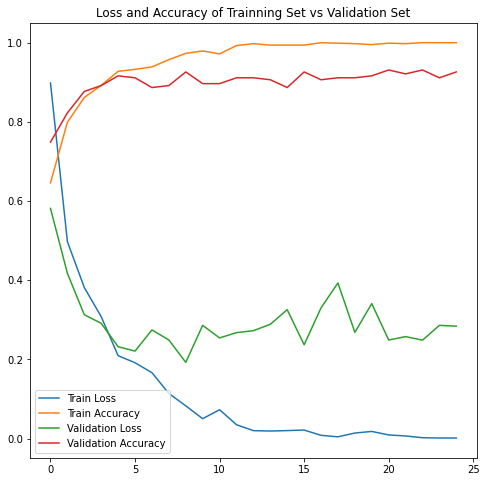

In [16]:
model_metrics.plot(figsize = (8,8))


L = plt.legend(loc = 3)
L.get_texts()[0].set_text('Train Loss')
L.get_texts()[1].set_text('Train Accuracy')
L.get_texts()[2].set_text('Validation Loss')
L.get_texts()[3].set_text('Validation Accuracy')


plt.title('Loss and Accuracy of Trainning Set vs Validation Set')

plt.savefig('DP_MODEL_EVALUATION.jpg')

In [17]:
import requests
from io import BytesIO

In [18]:
def make_img_array(url, img_size):
    """Take in an image from url and return as array for prediction."""
    img = requests.get(url)
    img = BytesIO(img.content)
    img = Image.open(img).resize(img_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    return img_array

In [19]:
#Make Predictions
#Dragonfly image from another database
predict_img_url = 'https://raw.githubusercontent.com/puzeng/BIOSTAT823_FALL21_Pu/main/dragonflies_bcc.jpeg'
predict_img = make_img_array(predict_img_url, img_size)

predict_img /= 255.0

prediction = model.predict(predict_img)
score = tf.nn.softmax(prediction[0])
categories = ['beetles', 'cockroach', 'dragonflies']

predict_class = categories[np.argmax(score)]
prob_class = np.round(100 * np.max(score), 2)

print(f'Based on the model, this image belongs to the class {predict_class} with probability of {prob_class}.')

Based on the model, this image belongs to the class dragonflies with probability of 49.34.


In [20]:
#Dragonfly image from Original Database
predict_img_url = 'https://raw.githubusercontent.com/puzeng/BIOSTAT823_FALL21_Pu/main/dragonflies_insecstimages.jpeg'
predict_img = make_img_array(predict_img_url, img_size)
predict_img /= 255.0
prediction = model.predict(predict_img)
score = tf.nn.softmax(prediction[0])
categories = ['beetles', 'cockroach', 'dragonflies']

predict_class = categories[np.argmax(score)]
prob_class = np.round(100 * np.max(score), 2)
print(f'Based on the model, this image belongs to the class {predict_class} with probability of {prob_class}.')

Based on the model, this image belongs to the class dragonflies with probability of 49.71.


In [55]:
X_train = np.concatenate([x for x, y in train_imgs], axis = 0)
Y_train = np.concatenate([y for x, y in train_imgs], axis = 0)

In [56]:
X_test = np.concatenate([x for x, y in test_imgs], axis = 0)
Y_test = np.concatenate([y for x, y in test_imgs], axis = 0)

In [66]:
explainer = shap.GradientExplainer(model, X_train)

In [67]:
np.random.seed(0)
sample = np.random.choice(len(X_test), 15, replace = False)
sample

array([106,   7, 125, 160, 136,  71,  56, 151, 162, 108,  33, 153, 158,
         5,  18])

In [68]:
shap_values_test, index = explainer.shap_values(X_test[sample], ranked_outputs = 3);

In [69]:
len(shap_values_test)

3

In [61]:
class_names = ['beetles', 'cockroach', 'dragonflies']

In [62]:
# get the names for the classes
index_names = np.vectorize(lambda x: class_names[x])(index)

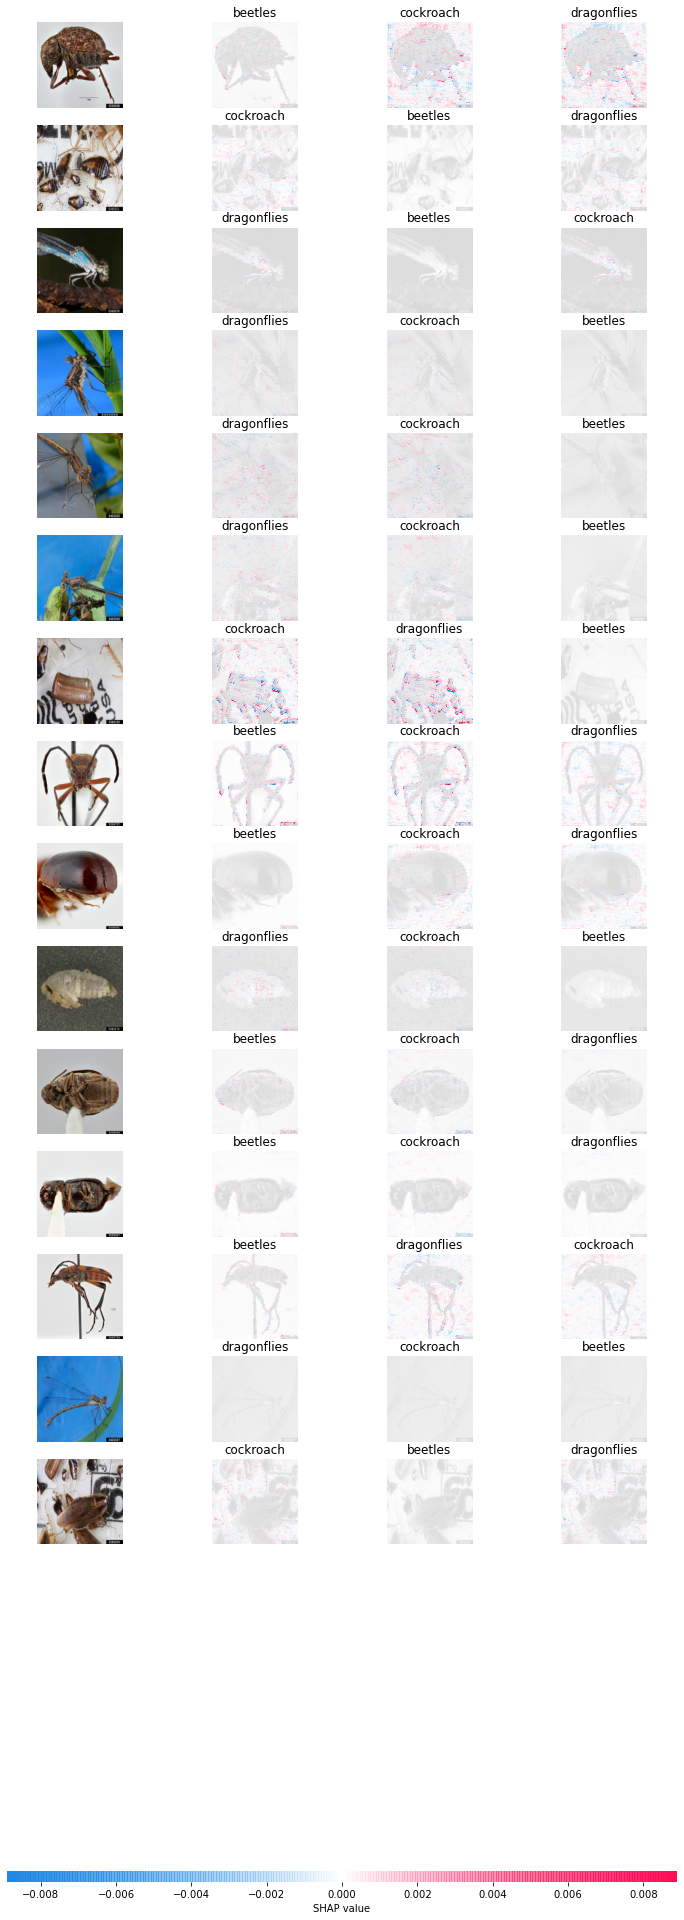

In [70]:
shap.image_plot(shap_values_test, 
                X_test[sample], 
                labels = index_names, 
                show = False)

plt.savefig('SHAP_DP_IMAGE_PREDICTION.jpg')